In [1]:
# This notebook will generate a map for all golden spikes in the isc2018-08 version of the 
# international stratigraphic chart

install.packages("dplyr")
install.packages("tidyr")
install.packages("leaflet")
install.packages("SPARQL")
install.packages("rworldmap")

Installing package into ‘/nethome/max/.R-libs’
(as ‘lib’ is unspecified)

Warning message in install.packages("dplyr"):
“installation of package ‘dplyr’ had non-zero exit status”
Installing package into ‘/nethome/max/.R-libs’
(as ‘lib’ is unspecified)

Installing package into ‘/nethome/max/.R-libs’
(as ‘lib’ is unspecified)

Installing package into ‘/nethome/max/.R-libs’
(as ‘lib’ is unspecified)

Installing package into ‘/nethome/max/.R-libs’
(as ‘lib’ is unspecified)



In [1]:
library(leaflet)
library(SPARQL)
library(stringr)
library(rworldmap)
library(dplyr)

Loading required package: XML

Loading required package: RCurl

Loading required package: sp

### Welcome to rworldmap ###

For a short introduction type : 	 vignette('rworldmap')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
endpoint = "http://virtuoso.nkn.uidaho.edu:8890/sparql/"

# attach SPARQL querry prefix. Note: the graph for our study should be updated
sparql_prefix = "
    prefix tssc: <http://deeptimekb.org/tssc#> 
    prefix tsnc: <http://deeptimekb.org/tsnc#> 
    prefix tswe: <http://deeptimekb.org/tswe#> 
    prefix tsbr: <http://deeptimekb.org/tsbr#>
    prefix tsba: <http://deeptimekb.org/tsba#> 
    prefix tsjp: <http://deeptimekb.org/tsjp#> 
    prefix tsau: <http://deeptimekb.org/tsau#>                   
    prefix tsnc: <http://deeptimekb.org/tsnc#> 
    prefix dc: <http://purl.org/dc/elements/1.1/> 
    prefix dcterms: <http://purl.org/dc/terms/> 
    prefix foaf: <http://xmlns.com/foaf/0.1/> 
    prefix geo: <http://www.opengis.net/ont/geosparql#> 
    prefix gts: <http://resource.geosciml.org/ontology/timescale/gts#> 
    prefix isc: <http://resource.geosciml.org/classifier/ics/ischart/> 
    prefix owl: <http://www.w3.org/2002/07/owl#> 
    prefix rank: <http://resource.geosciml.org/ontology/timescale/rank/> 
    prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
    prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
    prefix samfl: <http://def.seegrid.csiro.au/ontology/om/sam-lite#> 
    prefix sf: <http://www.opengis.net/ont/sf#> 
    prefix skos: <http://www.w3.org/2004/02/skos/core#> 
    prefix sosa: <http://www.w3.org/ns/sosa/> 
    prefix thors: <http://resource.geosciml.org/ontology/timescale/thors#> 
    prefix time: <http://www.w3.org/2006/time#> 
    prefix ts: <http://resource.geosciml.org/vocabulary/timescale/> 
    prefix vann: <http://purl.org/vocab/vann/> 
    prefix void: <http://rdfs.org/ns/void#> 
    prefix xkos: <http://rdf-vocabulary.ddialliance.org/xkos#> 
    prefix xsd: <http://www.w3.org/2001/XMLSchema#>
    
  "

In [3]:
# the query code to get all the global vocabulary schemes
 
q = paste0(
              sparql_prefix, 
                  '
                   SELECT DISTINCT ?schURI ?lbl
                   WHERE
                   {
                     GRAPH <http://deeptimekb.org/iscallnew> 
                     {
                        ?schURI a skos:ConceptScheme ;
                                rdfs:label ?lbl .
                        FILTER regex(?lbl, "International", "i")
                     }      
                   }
                   ORDER BY DESC (?schURI)
                  '
              )

# run the query  
resScheme = SPARQL(endpoint, q)$results


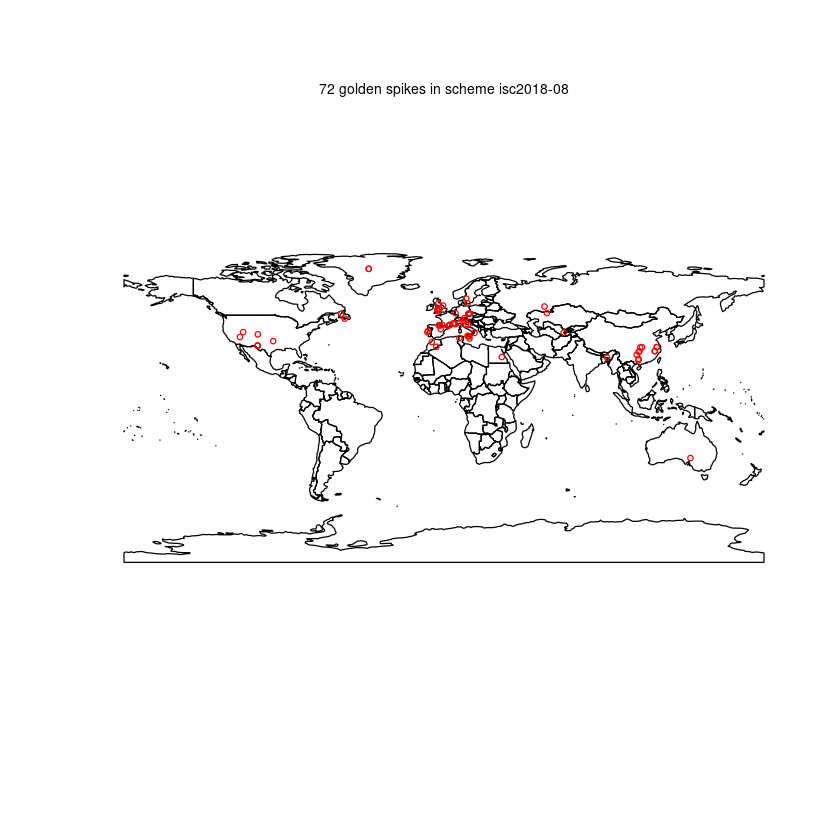

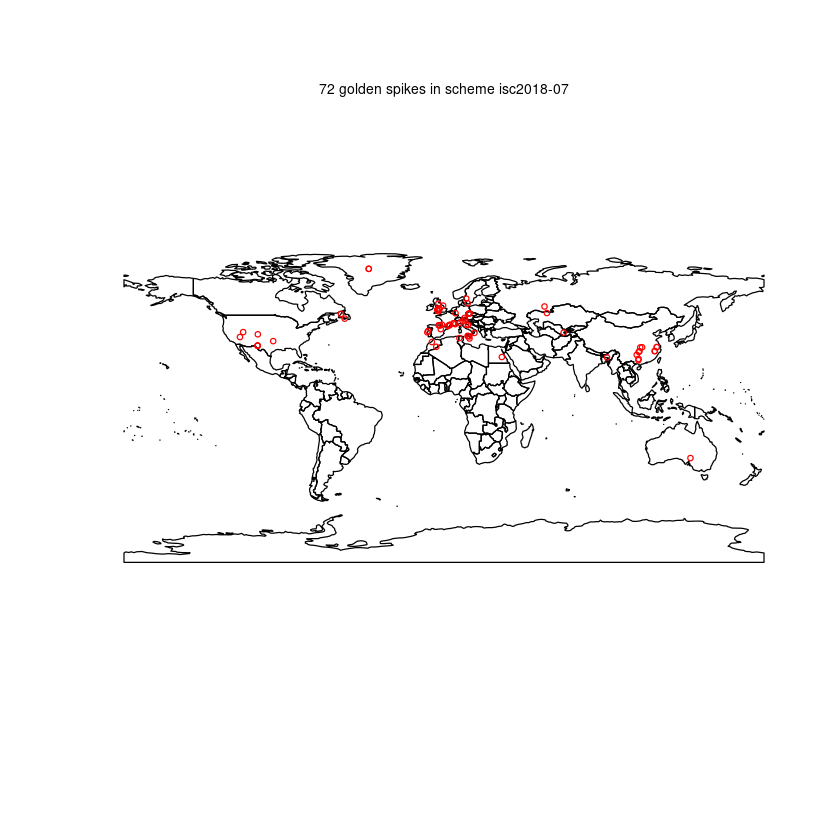

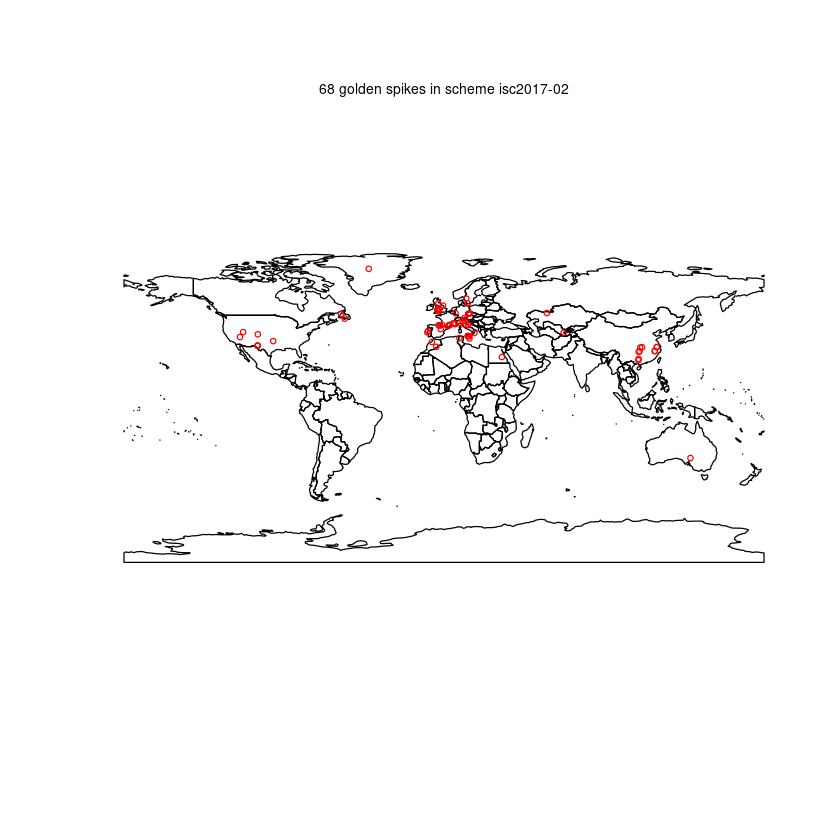

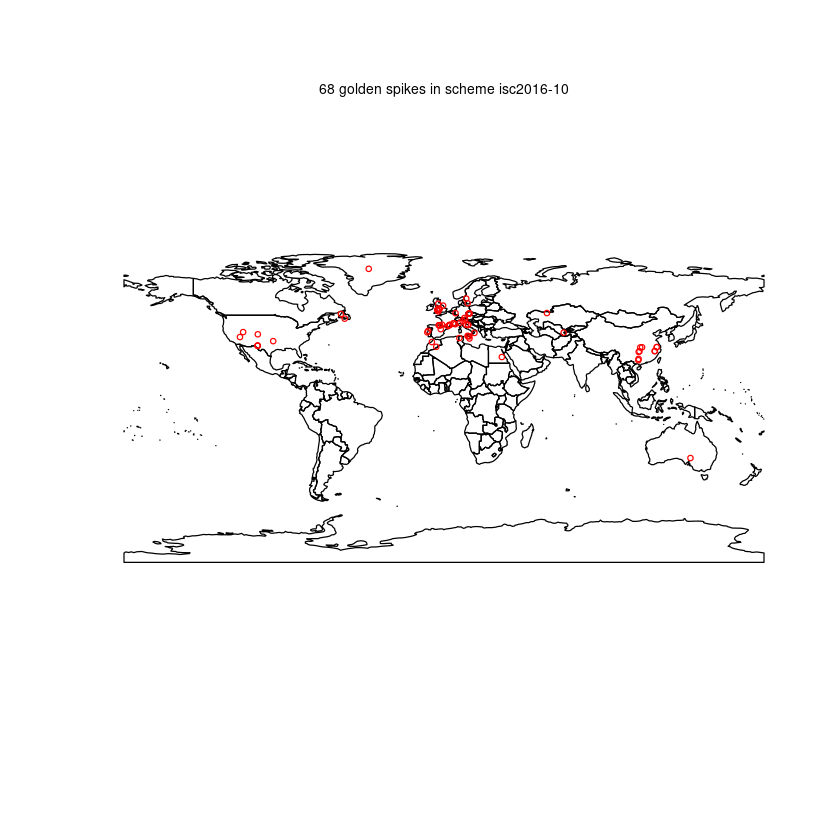

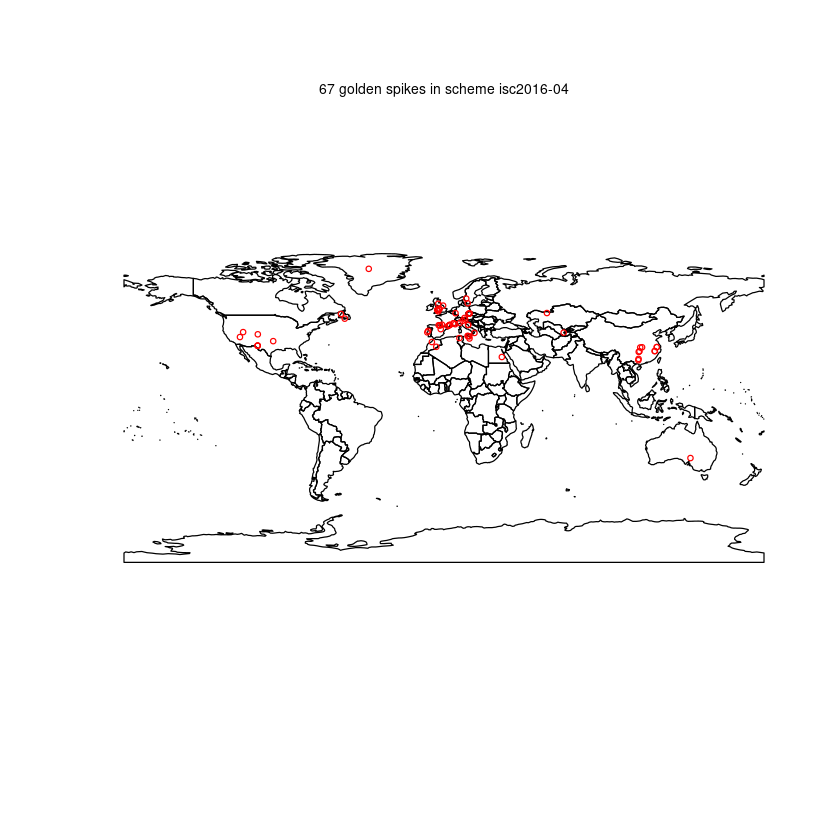

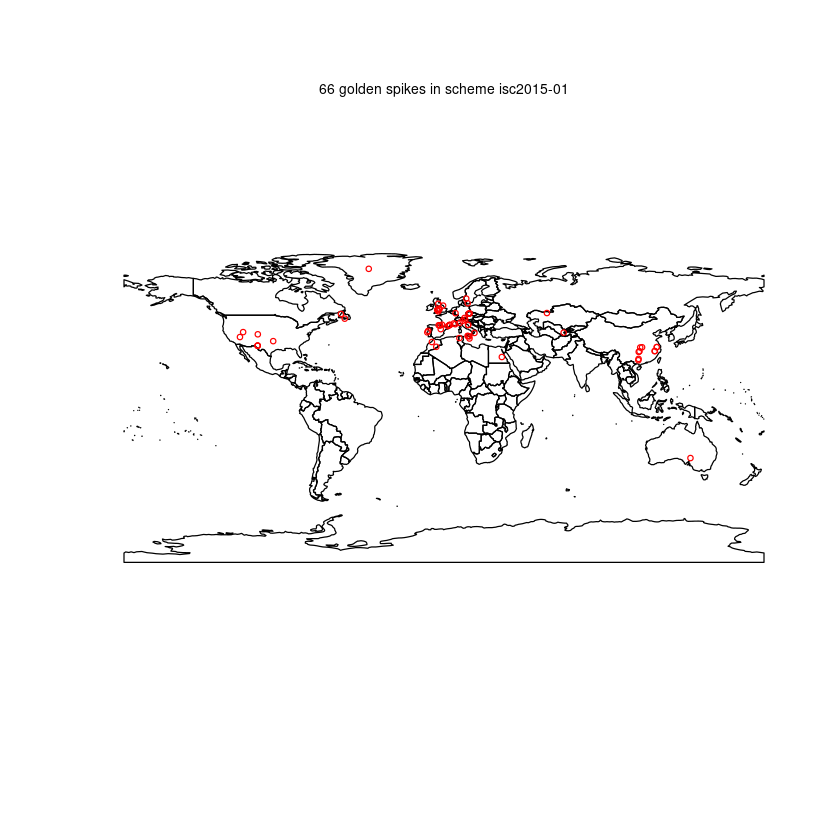

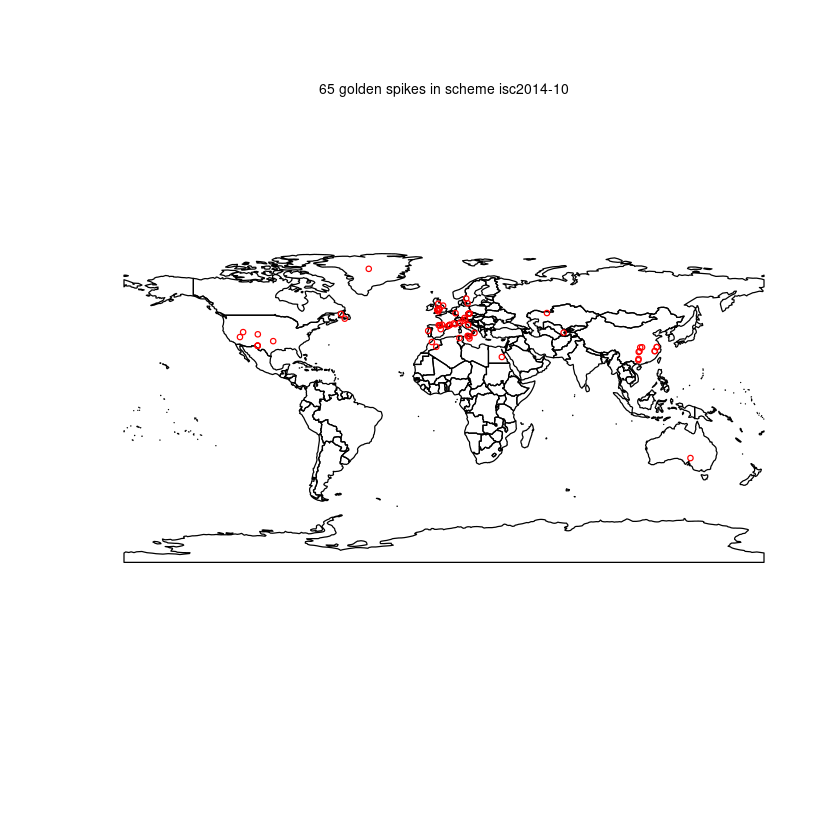

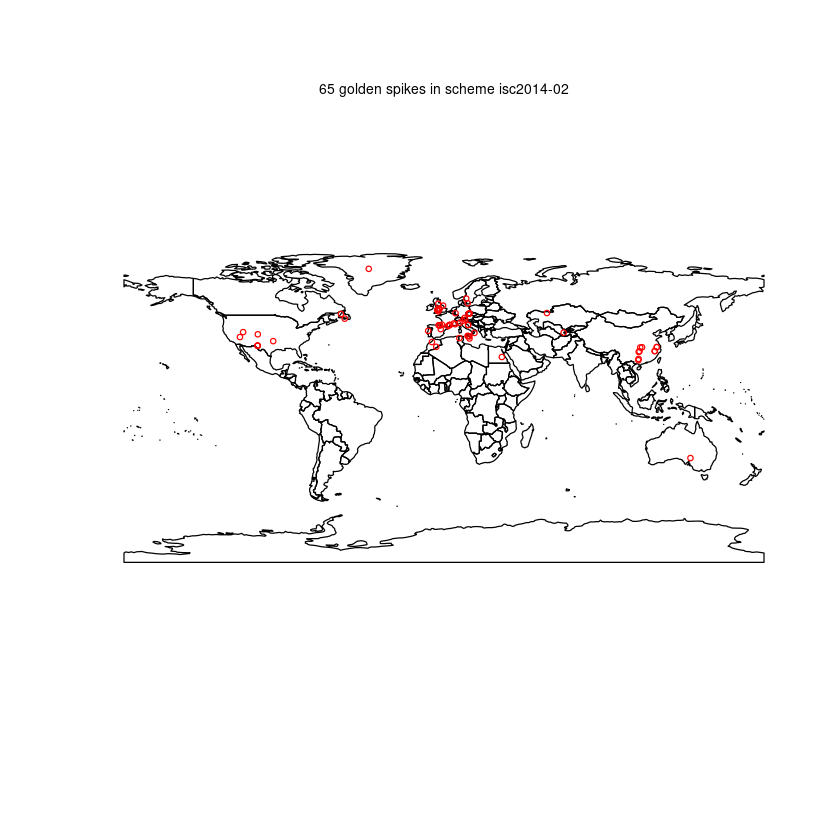

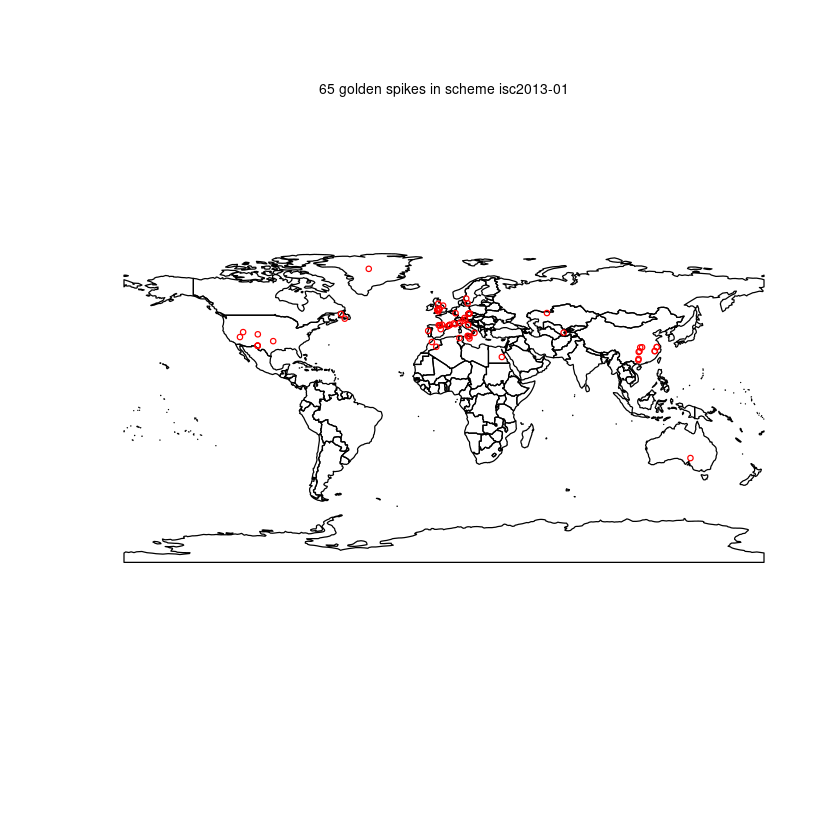

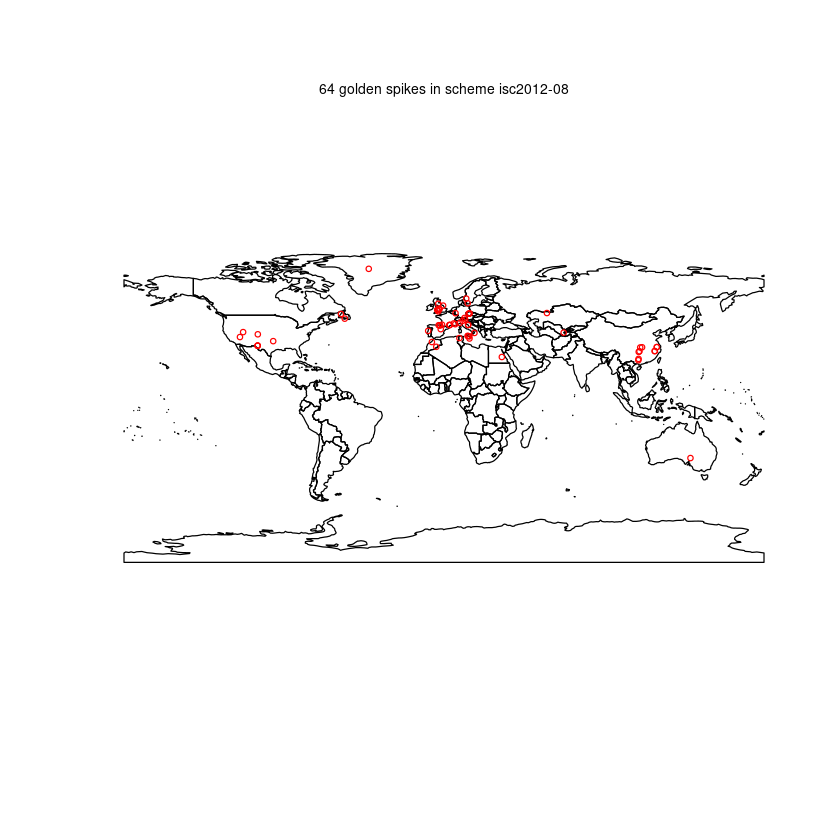

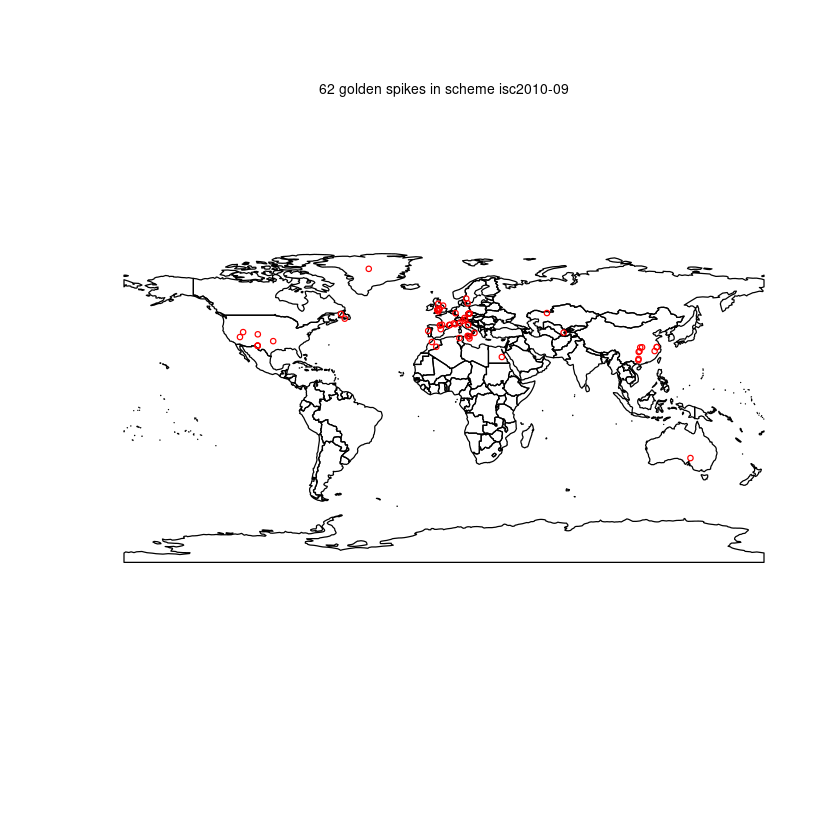

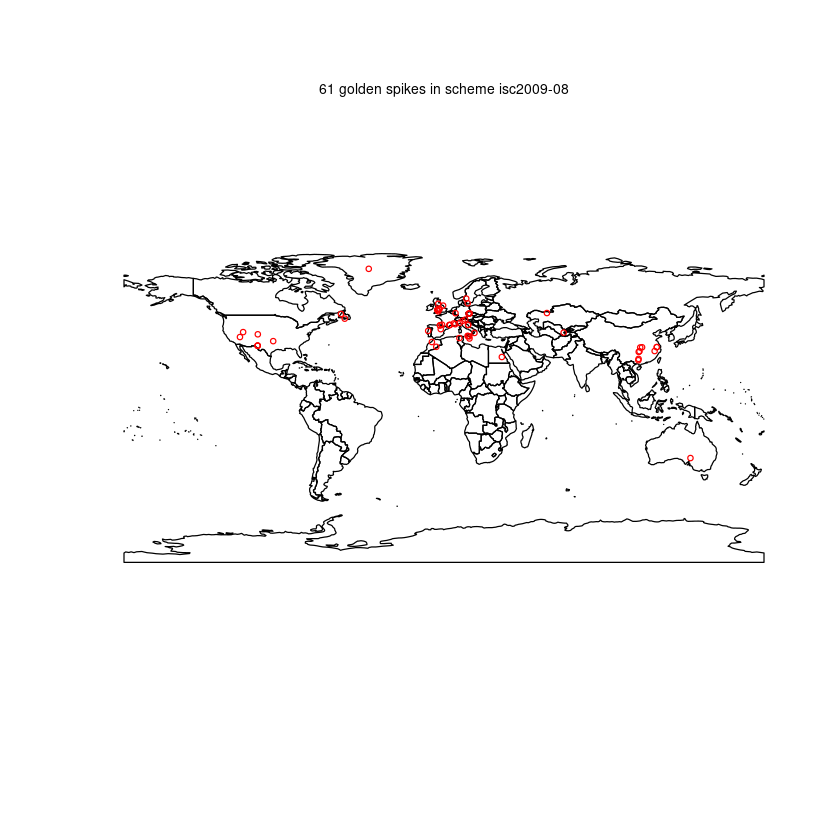

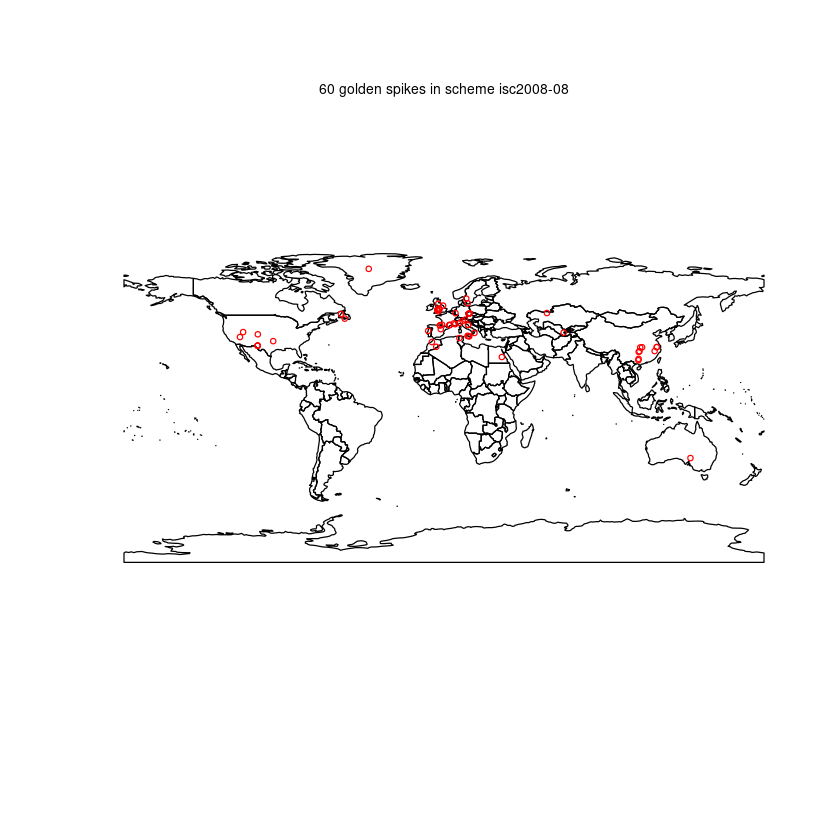

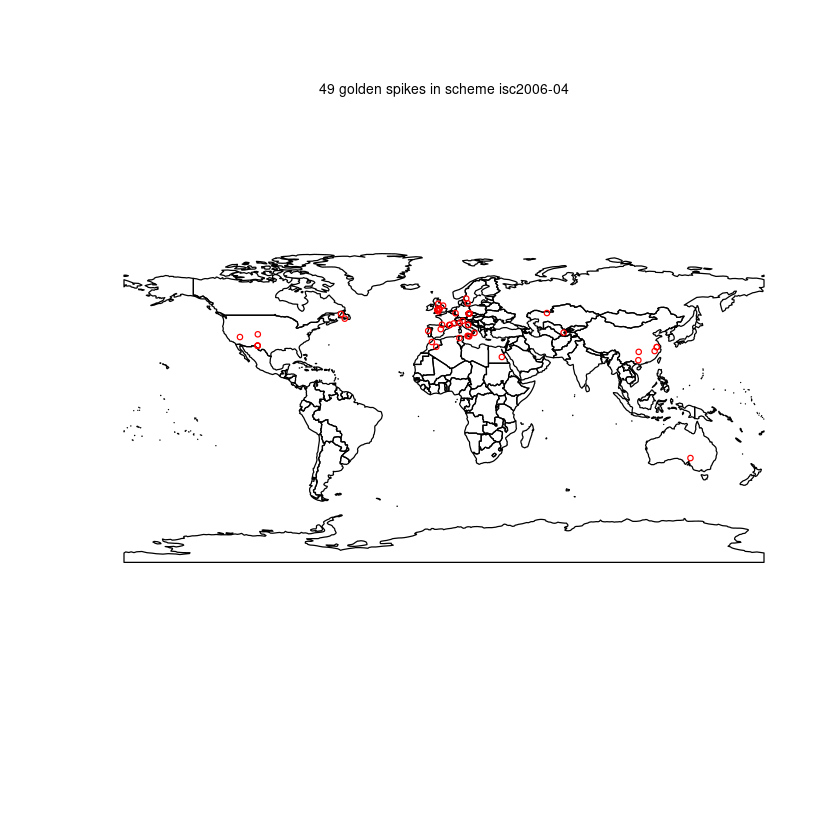

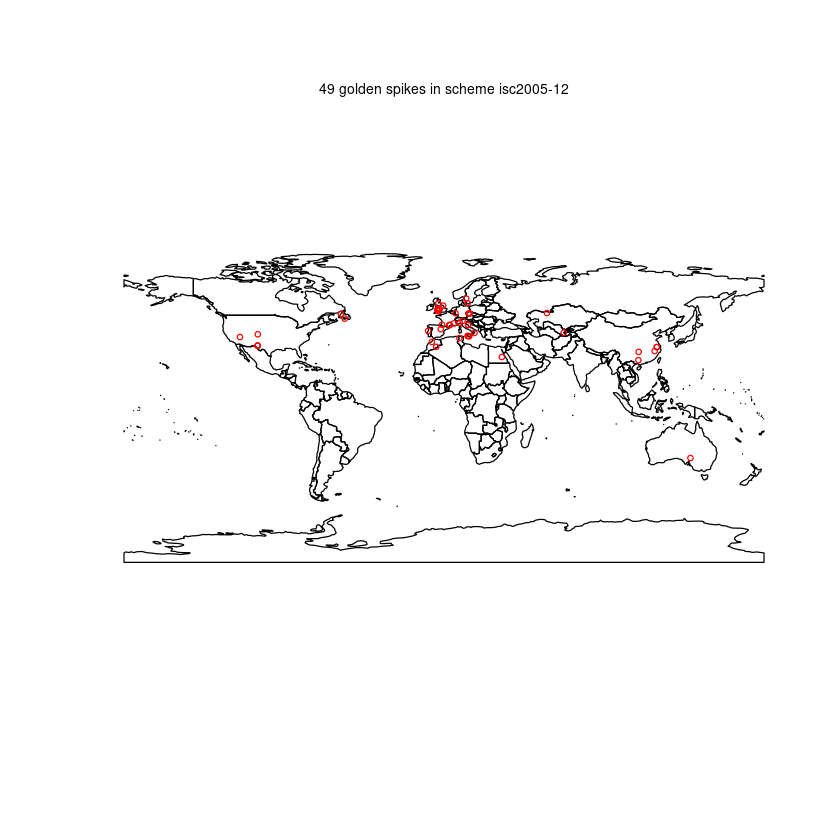

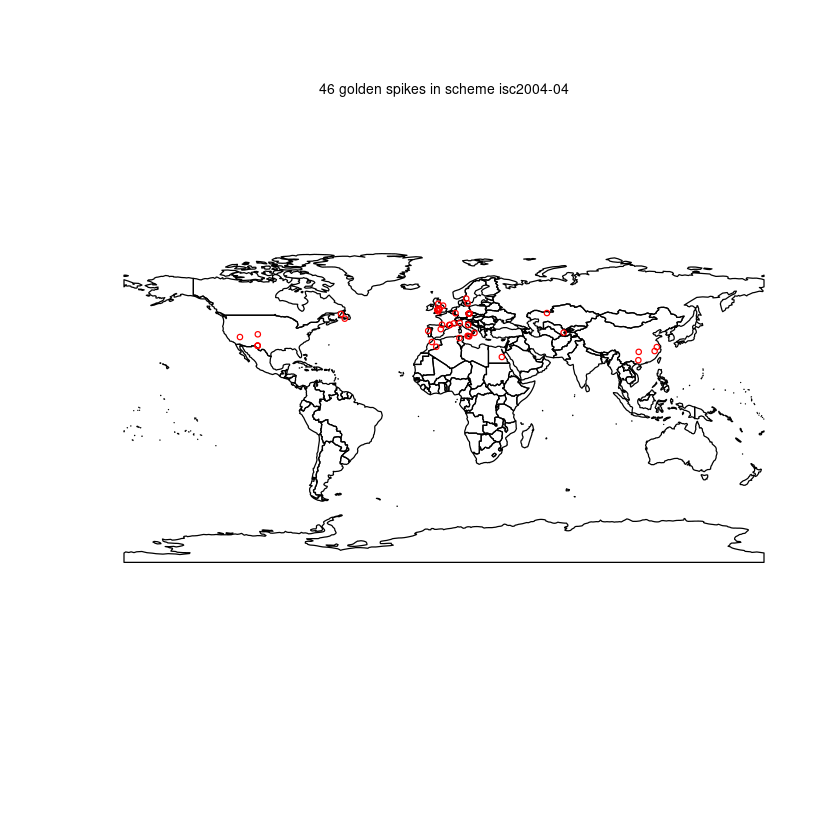

In [16]:
#plot a gssp map in image for each vocabulary scheme

for (k in 1:length(resScheme$schURI))
{
    cat("\n\n") 

    # run the query to get the list of GSSPs
    q1 = paste0(sparql_prefix, '
           SELECT DISTINCT (str(?spLabel) AS ?label1) (str(?spCoordinates) AS ?coord1)
    WHERE
    {

       GRAPH <http://deeptimekb.org/iscallnew>
       {   
           ?bdry  a gts:GeochronologicBoundary ;
                   dc:description
                   [
                     gts:stratotype ?baseSp ;
                     skos:inScheme ', resScheme$schURI[k], '
                   ] .

           ?baseSp samfl:shape ?spLocation ;  
                   rdfs:label ?spLabel ;
                   gts:ratifiedGSSP ?tf . 
            FILTER(regex(str(?tf), "true", "i"))

           ?spLocation geo:asWKT ?spCoordinates .
       }

    }
    ')
    res1 = SPARQL(endpoint, q1)$results 
    
  #take out only the long and lat records from the sparql query results
    longlat<-substr(res1$coord1, 7, nchar(res1$coord1)-1)
    concept <- substr(res1$label1, 25, nchar(res1$label1))

    longlatdata<-str_split_fixed(longlat, " ", 2)

    longlatdf <-data.frame(longlatdata)

    cleanStr<-substr(resScheme$schURI[k], 52, nchar(resScheme$schURI[k])-1)
    
    # print a static map
    newmap <- getMap(resolution = "coarse")
    plot(newmap, asp = 1)
      mtext( paste(length(res1$label1), "golden spikes in scheme", cleanStr), cex=0.7)
    # here we need to use this structure as.numeric( as.character(longlatdf$X1) ) to transform the variable in the data frame from 'factor' to 'numeric' and use it
      points( as.numeric( as.character(longlatdf$X1) ), as.numeric( as.character(longlatdf$X2) ), col = "red", cex = .6)
    
}



In [13]:
#create a pdf file and plot a gssp map for each vocabulary scheme as a page in the pdf

pdf("map-plots.pdf")

for (k in 1:length(resScheme$schURI))
{
    cat("\n\n") 

    # run the query to get the list of GSSPs
    q1 = paste0(sparql_prefix, '
           SELECT DISTINCT (str(?spLabel) AS ?label1) (str(?spCoordinates) AS ?coord1)
    WHERE
    {

       GRAPH <http://deeptimekb.org/iscallnew>
       {   
           ?bdry  a gts:GeochronologicBoundary ;
                   dc:description
                   [
                     gts:stratotype ?baseSp ;
                     skos:inScheme ', resScheme$schURI[k], '
                   ] .

           ?baseSp samfl:shape ?spLocation ;  
                   rdfs:label ?spLabel ;
                   gts:ratifiedGSSP ?tf . 
            FILTER(regex(str(?tf), "true", "i"))

           ?spLocation geo:asWKT ?spCoordinates .
       }

    }
    ')
    res1 = SPARQL(endpoint, q1)$results 
    
  #take out only the long and lat records from the sparql query results
    longlat<-substr(res1$coord1, 7, nchar(res1$coord1)-1)
    concept <- substr(res1$label1, 25, nchar(res1$label1))

    longlatdata<-str_split_fixed(longlat, " ", 2)

    longlatdf <-data.frame(longlatdata)

    cleanStr<-substr(resScheme$schURI[k], 52, nchar(resScheme$schURI[k])-1)
    
    # print a static map
    newmap <- getMap(resolution = "coarse")
    plot(newmap, asp = 1)
      mtext( paste(length(res1$label1), "golden spikes in scheme", cleanStr), cex=0.7)
    # here we need to use this structure as.numeric( as.character(longlatdf$X1) ) to transform the variable in the data frame from 'factor' to 'numeric' and use it
      points( as.numeric( as.character(longlatdf$X1) ), as.numeric( as.character(longlatdf$X2) ), col = "red", cex = .6)
    
}

dev.off() 


png 
  2